## Cancer Risk Prediction Model (PART2)

### Decision Tree Classifier

The steps of this method (Data Processing and Model Interaction, Data Encoding, etc.) are described in more detail in PART 1.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from itertools import combinations
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

file_path = "cancer prediction dataset - My(version(colorec+gastric+esophegael)).csv"

# 1: Load Data
def load_data(file_path):
    """Loads CSV dataset into a Pandas DataFrame."""
    return pd.read_csv(file_path)

# 2: Encode Categorical Columns
def encode_effect_strength(df):
    """Encodes 'Effect' and 'Evidence Strength' columns."""
    df['Effect'] = df['Effect'].map({'Protective': 0, 'Negative': 1})
    df['Evidence Strength'] = df['Evidence Strength'].map({'Weak evidence': 1, 'Moderate evidence': 2, 'Strong evidence': 3})
    return df

# 3: Encode 'Cancer Type'
def encode_cancer_type(df):
    """Encodes 'Cancer Type' as numerical labels."""
    label_encoder = LabelEncoder()
    df['Cancer Type'] = label_encoder.fit_transform(df['Cancer Type'])
    return df, label_encoder

# 4: Aggregate Risk Factors into Patient Profiles
def generate_patient_profiles(df, num_patients=1000, risk_factors_per_patient=4):
    """Creates synthetic patient profiles by randomly assigning multiple risk factors per patient."""
    unique_risk_factors = df['Risk Factor'].unique()
    patients = []
    
    for _ in range(num_patients):
        selected_risks = np.random.choice(unique_risk_factors, risk_factors_per_patient, replace=False)
        filtered_df = df[df['Risk Factor'].isin(selected_risks)]
        
        # Aggregate numerical features
        numeric_cols = ['Effect', 'Evidence Strength']
        patient_data = filtered_df.groupby('Cancer Type')[numeric_cols].mean().reset_index()

        # Keep Risk Factor as a concatenated string
        patient_data['Risk Factors'] = ", ".join(selected_risks)
        patient_data['Patient ID'] = _  
        
        patients.append(patient_data)
    
    return pd.concat(patients, ignore_index=True)

# 5: One-Hot Encode Risk Factors
def encode_risk_factors(df):
    """Encodes multiple risk factors per patient using multi-label binarization and saves the encoder."""
    df['Risk Factors'] = df['Risk Factors'].apply(lambda x: x.split(', '))
    mlb = MultiLabelBinarizer()
    risk_factor_encoded = mlb.fit_transform(df['Risk Factors'])
    risk_factor_df = pd.DataFrame(risk_factor_encoded, columns=mlb.classes_)
    
    return pd.concat([df.drop(columns=['Risk Factors']), risk_factor_df], axis=1)

# 6: Train Decision Tree Model and Evaluate Metrics
def train_decision_tree(df):
    """Trains a Decision Tree classifier and returns the trained model along with evaluation metrics."""
    X = df.drop(columns=['Cancer Type', 'Patient ID'])
    y = df['Cancer Type']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    report = classification_report(y_test, y_test_pred)
    
    metrics = {
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Classification Report": report
    }
    
    return model, metrics

# 7: Run the Entire Preprocessing Pipeline
def preprocess_pipeline(file_path):
    """Runs all preprocessing steps and returns the final DataFrame along with model metrics."""
    df = load_data(file_path)
    df = encode_effect_strength(df)
    df, label_encoder = encode_cancer_type(df)
    df = generate_patient_profiles(df)
    df = encode_risk_factors(df)
    model, metrics = train_decision_tree(df)
    return df, model, metrics, label_encoder

df, model_dt, metrics_dt, label_enc_dt = preprocess_pipeline(file_path)

In [26]:
for key, value in metrics_dt.items():
    print(f"{key}: {value}")

Train Accuracy: 0.9266666666666666
Test Accuracy: 0.44333333333333336
Precision: 0.44458708504491296
Recall: 0.44333333333333336
F1 Score: 0.44382357621171764
Classification Report:               precision    recall  f1-score   support

           0       0.46      0.45      0.45       206
           1       0.39      0.42      0.40       183
           2       0.48      0.46      0.47       211

    accuracy                           0.44       600
   macro avg       0.44      0.44      0.44       600
weighted avg       0.44      0.44      0.44       600



### Decision Tree Classifier: Optimization

In [27]:
# 6: Train Decision Tree Model and Evaluate Metrics
def train_decision_tree(df):
    """Trains a Decision Tree classifier and returns the trained model along with evaluation metrics."""
    X = df.drop(columns=['Cancer Type', 'Patient ID'])
    y = df['Cancer Type']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'ccp_alpha': [0.0001, 0.001, 0.01, 0.1] 
    }
    
    model = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    report = classification_report(y_test, y_test_pred)
    
    metrics = {
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Classification Report": report,
        "Best Parameters": grid_search.best_params_
    }
    
    return best_model, metrics

In [28]:
df_dt_hyper, model_dt_hyper, metrics_dt_hyper, label_enc_dt_hyper = preprocess_pipeline(file_path)

In [29]:
for key, value in metrics_dt_hyper.items():
    print(f"{key}: {value}")

Train Accuracy: 0.6098374322634431
Test Accuracy: 0.455
Precision: 0.45745625175339893
Recall: 0.455
F1 Score: 0.4549905850900391
Classification Report:               precision    recall  f1-score   support

           0       0.47      0.46      0.46       206
           1       0.48      0.42      0.45       208
           2       0.42      0.48      0.45       186

    accuracy                           0.46       600
   macro avg       0.46      0.46      0.45       600
weighted avg       0.46      0.46      0.45       600

Best Parameters: {'ccp_alpha': 0.001, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


### Random Forest Classifier

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

class SimplifiedECHORF:
    """
    Simplified Cancer Classification System
    Core functionality with only classification - no regression
    """
    
    def __init__(self):
        self.classifier = None
        self.df_encoded = None
        self.frequency_df = None
        self.cancer_encoder = None
        self.feature_names = None
        self.scaler = None

    def load_data(self, file_path):
        """Load cancer risk dataset from CSV file."""
        try:
            df = pd.read_csv(file_path)
            print(f"Dataset loaded: {len(df)} records")
            return df
        except Exception as e:
            print(f"Error loading dataset: {e}")
            return None

    def encode_categorical_features(self, df):
        """Encode categorical features with robust mapping."""
        df_encoded = df.copy()
        
        df_encoded['Effect'] = df_encoded['Effect'].fillna('Negative')
        df_encoded['Evidence Strength'] = df_encoded['Evidence Strength'].fillna('Weak evidence')
        
        def map_effect(value):
            value_str = str(value).lower().strip()
            if 'protective' in value_str or 'benefit' in value_str:
                return -1
            else:
                return 1
        
        #the values are taken based on the articles
        def map_evidence(value):
            value_str = str(value).lower().strip()
            if 'strong' in value_str:
                return 0.50
            elif 'moderate' in value_str:
                return 0.30
            else:
                return 0.10
        
        df_encoded['Effect_Numeric'] = df_encoded['Effect'].apply(map_effect)
        df_encoded['Evidence_Numeric'] = df_encoded['Evidence Strength'].apply(map_evidence)
        df_encoded['Risk_Coefficient'] = df_encoded['Effect_Numeric'] * df_encoded['Evidence_Numeric']
        
        print(f"Categorical features encoded")
        return df_encoded

    def calculate_risk_factor_frequency(self, df):
        """Calculate frequency of each risk factor by cancer type."""
        frequency_df = df.groupby(['Risk Factor', 'Cancer Type']).size().reset_index(name='frequency')
        print(f"Risk factor frequencies calculated")
        return frequency_df

    def generate_patient_profiles(self, df_encoded, frequency_df, num_patients=1000):
        """Generate synthetic patient profiles with hybrid encoding."""
        all_risk_factors = df_encoded['Risk Factor'].unique()
        all_cancer_types = df_encoded['Cancer Type'].unique()
        
        valid_risk_factors = [f for f in all_risk_factors if pd.notna(f) and isinstance(f, str)]
        valid_cancer_types = [c for c in all_cancer_types if pd.notna(c) and isinstance(c, str)]
        
        cancer_encoder = LabelEncoder()
        cancer_encoder.fit(valid_cancer_types)
        
        freq_dict = {}
        for _, row in frequency_df.iterrows():
            if pd.notna(row['Risk Factor']) and pd.notna(row['Cancer Type']):
                key = (row['Risk Factor'], row['Cancer Type'])
                freq_dict[key] = row['frequency']
        
        np.random.seed(42)
        patients = []
        
        for i in range(num_patients):
            cancer_type = np.random.choice(valid_cancer_types)
            
            # Select 3-4 risk factors (some cancer-specific, some random)
            cancer_factors = df_encoded[df_encoded['Cancer Type'] == cancer_type]['Risk Factor'].unique()
            cancer_factors = [f for f in cancer_factors if pd.notna(f) and isinstance(f, str)]
            
            if len(cancer_factors) >= 2:
                #70% cancer-specific factors
                selected_risks = list(np.random.choice(cancer_factors, 2, replace=False))
                #30% random factors
                other_factors = [f for f in valid_risk_factors if f not in selected_risks]
                if other_factors:
                    selected_risks.extend(list(np.random.choice(other_factors, 
                                                               min(2, len(other_factors)), 
                                                               replace=False)))
            else:
                selected_risks = list(np.random.choice(valid_risk_factors, 3, replace=False))
            
            patients.append({
                'patient_id': i,
                'cancer_type': cancer_type,
                'risk_factors': selected_risks
            })
        
        patients_df = pd.DataFrame(patients)
        
        # 1. One-hot encoding for risk factors
        one_hot_matrix = np.zeros((len(patients_df), len(valid_risk_factors)))
        for i, patient in enumerate(patients_df.iterrows()):
            for j, rf in enumerate(valid_risk_factors):
                if rf in patient[1]['risk_factors']:
                    one_hot_matrix[i, j] = 1
        
        # 2. Frequency features
        freq_features = np.zeros((len(patients_df), len(valid_risk_factors)))
        for i, (_, patient) in enumerate(patients_df.iterrows()):
            cancer_type = patient['cancer_type']
            for j, rf in enumerate(valid_risk_factors):
                if rf in patient['risk_factors']:
                    freq = freq_dict.get((rf, cancer_type), 1)
                    freq_multiplier = min(1.0 + (freq - 1) * 0.05, 1.15)
                    freq_features[i, j] = freq_multiplier
        
        # 3. Coefficient features
        coef_features = np.zeros((len(patients_df), len(valid_risk_factors)))
        for i, (_, patient) in enumerate(patients_df.iterrows()):
            cancer_type = patient['cancer_type']
            for j, rf in enumerate(valid_risk_factors):
                if rf in patient['risk_factors']:
                    rf_data = df_encoded[(df_encoded['Risk Factor'] == rf) & 
                                       (df_encoded['Cancer Type'] == cancer_type)]
                    if not rf_data.empty:
                        coef = rf_data['Risk_Coefficient'].mean()
                        freq = freq_dict.get((rf, cancer_type), 1)
                        freq_multiplier = min(1.0 + (freq - 1) * 0.05, 1.15)
                        coef_features[i, j] = coef * freq_multiplier
        
        # all features combinations
        X = np.hstack([one_hot_matrix, freq_features, coef_features])
        y = cancer_encoder.transform(patients_df['cancer_type'])
        
        # Create feature names
        feature_names = (list(valid_risk_factors) + 
                        [f'Freq_{rf}' for rf in valid_risk_factors] +
                        [f'Coef_{rf}' for rf in valid_risk_factors])
        
        print(f"Generated {num_patients} synthetic patients with {X.shape[1]} features")
        return X, y, feature_names, cancer_encoder

    def train_classifier(self, X, y, feature_names, cancer_types):
        """Train classification model with comprehensive metrics."""
        X = np.nan_to_num(X, nan=0.0, posinf=1.0, neginf=0.0)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        self.classifier = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        
        self.classifier.fit(X_train_scaled, y_train)
        
        y_train_pred = self.classifier.predict(X_train_scaled)
        y_test_pred = self.classifier.predict(X_test_scaled)
        
        classification_metrics = {
            'train_accuracy': accuracy_score(y_train, y_train_pred),
            'test_accuracy': accuracy_score(y_test, y_test_pred),
            'train_precision': precision_score(y_train, y_train_pred, average='weighted'),
            'test_precision': precision_score(y_test, y_test_pred, average='weighted'),
            'train_recall': recall_score(y_train, y_train_pred, average='weighted'),
            'test_recall': recall_score(y_test, y_test_pred, average='weighted'),
            'train_f1': f1_score(y_train, y_train_pred, average='weighted'),
            'test_f1': f1_score(y_test, y_test_pred, average='weighted'),
            'classification_report': classification_report(y_test, y_test_pred, target_names=cancer_types)
        }
        
        print(f"\nCLASSIFICATION METRICS:")
        print(f"   Train Accuracy: {classification_metrics['train_accuracy']:.4f}")
        print(f"   Test Accuracy:  {classification_metrics['test_accuracy']:.4f}")
        print(f"   Train Precision: {classification_metrics['train_precision']:.4f}")
        print(f"   Test Precision:  {classification_metrics['test_precision']:.4f}")
        print(f"   Train Recall: {classification_metrics['train_recall']:.4f}")
        print(f"   Test Recall:  {classification_metrics['test_recall']:.4f}")
        print(f"   Train F1: {classification_metrics['train_f1']:.4f}")
        print(f"   Test F1:  {classification_metrics['test_f1']:.4f}")
        print(f"   Overfitting Gap: {classification_metrics['train_accuracy'] - classification_metrics['test_accuracy']:.4f}")
        
        return classification_metrics

    def predict_cancer_type(self, patient_risk_factors):
        """Predict cancer type for a patient with given risk factors."""
        if self.classifier is None or self.scaler is None:
            print("Models not trained yet")
            return None
        
        n_risk_factors = len(self.feature_names) // 3  # one-hot + freq + coef
        feature_vector = np.zeros(len(self.feature_names))
        
        factors_found = []
        
        for factor in patient_risk_factors:
            matched_factor = None
            
            if factor in self.feature_names[:n_risk_factors]:
                matched_factor = factor
            else:
                available_factors = self.feature_names[:n_risk_factors]
                for available in available_factors:
                    if factor.lower() in available.lower() or available.lower() in factor.lower():
                        matched_factor = available
                        break
                
                if matched_factor is None:
                    factor_words = factor.lower().split()
                    for available in available_factors:
                        available_words = available.lower().split()
                        if any(word in available_words for word in factor_words if len(word) > 2):
                            matched_factor = available
                            break
            
            if matched_factor:
                factors_found.append(matched_factor)
                
                # component 1: One-hot encoding
                idx = self.feature_names.index(matched_factor)
                feature_vector[idx] = 1
                
                # component 2: Frequency features
                freq_feature = f'Freq_{matched_factor}'
                if freq_feature in self.feature_names:
                    idx_freq = self.feature_names.index(freq_feature)
                    # Get actual frequency from training data
                    if self.frequency_df is not None:
                        factor_freq_data = self.frequency_df[self.frequency_df['Risk Factor'] == matched_factor]
                        if not factor_freq_data.empty:
                            avg_freq = factor_freq_data['frequency'].mean()
                            freq_multiplier = min(1.0 + (avg_freq - 1) * 0.05, 1.15)
                            feature_vector[idx_freq] = freq_multiplier
                        else:
                            feature_vector[idx_freq] = 1.1  # Default
                    else:
                        feature_vector[idx_freq] = 1.1
                
                # component 3: Coefficient features
                coef_feature = f'Coef_{matched_factor}'
                if coef_feature in self.feature_names:
                    idx_coef = self.feature_names.index(coef_feature)
                    if self.df_encoded is not None:
                        factor_data = self.df_encoded[self.df_encoded['Risk Factor'] == matched_factor]
                        if not factor_data.empty:
                            coef = factor_data['Risk_Coefficient'].mean()
                            # Get frequency multiplier for coefficient calculation
                            freq_mult = feature_vector[idx_freq] if 'idx_freq' in locals() else 1.1
                            feature_vector[idx_coef] = coef * freq_mult
        
        if len(factors_found) == 0:
            # add small noise 
            noise = np.random.normal(0, 0.01, len(feature_vector))
            feature_vector += noise
        
        feature_vector_scaled = self.scaler.transform(feature_vector.reshape(1, -1))
        
        # predictions
        class_proba = self.classifier.predict_proba(feature_vector_scaled)[0]
        predicted_class = self.classifier.predict(feature_vector_scaled)[0]
        predicted_cancer = self.cancer_encoder.classes_[predicted_class]
        
        return {
            'predicted_cancer_type': predicted_cancer,
            'class_probabilities': dict(zip(self.cancer_encoder.classes_, class_proba)),
            'max_class_probability': np.max(class_proba),
            'factors_found': factors_found,
            'factors_requested': patient_risk_factors
        }

    def train_complete_system(self, file_path):
        """Complete training pipeline."""
        print("Starting ECHO-RF Classification Training Pipeline")
        print("=" * 50)
        
        df = self.load_data(file_path)
        if df is None:
            return None
        
        self.df_encoded = self.encode_categorical_features(df)
        self.frequency_df = self.calculate_risk_factor_frequency(self.df_encoded)
        
        X, y, feature_names, cancer_encoder = self.generate_patient_profiles(
            self.df_encoded, self.frequency_df
        )
        
        self.cancer_encoder = cancer_encoder
        self.feature_names = feature_names
        cancer_types = cancer_encoder.classes_
        
        metrics = self.train_classifier(X, y, feature_names, cancer_types)
        
        print("ECHO-RF Classification Training Complete!")
        print(f"Cancer types: {list(cancer_types)}")
        print(f"Features: {len(feature_names)}")
        
        return metrics

def test():
    print("ECHO-RF Cancer Classification Test")
    print("=" * 50)
    
    model = SimplifiedECHORF()
    file_path = "cancer prediction dataset - My(version(colorec+gastric+esophegael)).csv"
    metrics = model.train_complete_system(file_path)
    
    if metrics is None:
        print("Training failed")
        return
    
    print("OMPREHENSIVE CLASSIFICATION RESULTS")
    print("=" * 60)
    
    print(f"CLASSIFICATION PERFORMANCE:")
    print(f"   Training Accuracy:   {metrics['train_accuracy']:.4f}")
    print(f"   Testing Accuracy:    {metrics['test_accuracy']:.4f}")
    print(f"   Training Precision:  {metrics['train_precision']:.4f}")
    print(f"   Testing Precision:   {metrics['test_precision']:.4f}")
    print(f"   Training Recall:     {metrics['train_recall']:.4f}")
    print(f"   Testing Recall:      {metrics['test_recall']:.4f}")
    print(f"   Training F1:         {metrics['train_f1']:.4f}")
    print(f"   Testing F1:          {metrics['test_f1']:.4f}")
    print(f"   Overfitting Gap:     {metrics['train_accuracy'] - metrics['test_accuracy']:.4f}")
    
    print(f"\nDETAILED CLASSIFICATION REPORT:")
    print(metrics['classification_report'])
    
    # testing
    test_cases = [
        (['Smoking', 'Alcohol consumption'], "High-risk patient"),
        (['Processed meat', 'Red meat'], "Colorectal risk patient"),
        (['Salt intake'], "Gastric risk patient"),
        ([], "Low-risk patient")
    ]
    
    print("Testing Predictions")
    print("=" * 50)
    
    for risk_factors, description in test_cases:
        print(f"\n{description}: {risk_factors if risk_factors else 'No risk factors'}")
        
        result = model.predict_cancer_type(risk_factors)
        
        if result:
            print(f"  Predicted: {result['predicted_cancer_type']}")
            print(f"  Confidence: {result['max_class_probability']:.3f}")
            print(f"  Factors found: {result['factors_found']}")
            
            probs = result['class_probabilities']
            sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)
            for cancer, prob in sorted_probs:
                print(f"    {cancer}: {prob:.3f}")
        else:
            print("Prediction failed")

if __name__ == "__main__":
    test()

ECHO-RF Cancer Classification Demo
Starting ECHO-RF Classification Training Pipeline
Dataset loaded: 948 records
Categorical features encoded
Risk factor frequencies calculated
Generated 1000 synthetic patients with 123 features

CLASSIFICATION METRICS:
   Train Accuracy: 0.9738
   Test Accuracy:  0.9650
   Train Precision: 0.9756
   Test Precision:  0.9682
   Train Recall: 0.9738
   Test Recall:  0.9650
   Train F1: 0.9739
   Test F1:  0.9654
   Overfitting Gap: 0.0088
ECHO-RF Classification Training Complete!
Cancer types: [np.str_('Colorectal cancer'), np.str_('Esophageal cancer'), np.str_('Gastric cancer')]
Features: 123
OMPREHENSIVE CLASSIFICATION RESULTS
CLASSIFICATION PERFORMANCE:
   Training Accuracy:   0.9738
   Testing Accuracy:    0.9650
   Training Precision:  0.9756
   Testing Precision:   0.9682
   Training Recall:     0.9738
   Testing Recall:      0.9650
   Training F1:         0.9739
   Testing F1:          0.9654
   Overfitting Gap:     0.0088

DETAILED CLASSIFICATION

### Deep Feedforward Neural Network (DNN)

- Architecture: Multi-Layer Perceptron (MLP)
- Activation Function: ReLU
- Optimization: Stochastic Gradient Descent (SGD) with Momentum
- Loss Function: Cross-Entropy Loss (for multi-class classification)
- Regularization: Batch Normalization & Dropout
- Learning Strategy: Early Stopping

Input Size: 263
Number of Classes: 3

 Training Neural Network...
Epoch 1/50, Train Loss: 1.1214, Train Accuracy: 33.94%, Val Loss: 1.0120, Val Accuracy: 53.52%
Epoch 2/50, Train Loss: 0.9961, Train Accuracy: 37.10%, Val Loss: 0.8916, Val Accuracy: 75.35%
Epoch 3/50, Train Loss: 0.8520, Train Accuracy: 35.60%, Val Loss: 0.6964, Val Accuracy: 78.17%
Epoch 4/50, Train Loss: 0.6007, Train Accuracy: 35.90%, Val Loss: 0.5421, Val Accuracy: 80.28%
Epoch 5/50, Train Loss: 0.4716, Train Accuracy: 33.94%, Val Loss: 0.5040, Val Accuracy: 80.28%
Epoch 6/50, Train Loss: 0.3969, Train Accuracy: 34.39%, Val Loss: 0.5015, Val Accuracy: 79.58%
Epoch 7/50, Train Loss: 0.3378, Train Accuracy: 31.98%, Val Loss: 0.4983, Val Accuracy: 83.10%
Epoch 8/50, Train Loss: 0.2888, Train Accuracy: 30.02%, Val Loss: 0.4945, Val Accuracy: 82.39%
Epoch 9/50, Train Loss: 0.2744, Train Accuracy: 34.84%, Val Loss: 0.5082, Val Accuracy: 82.39%
Epoch 10/50, Train Loss: 0.2417, Train Accuracy: 31.07%, Val Loss: 0.5174, Val 

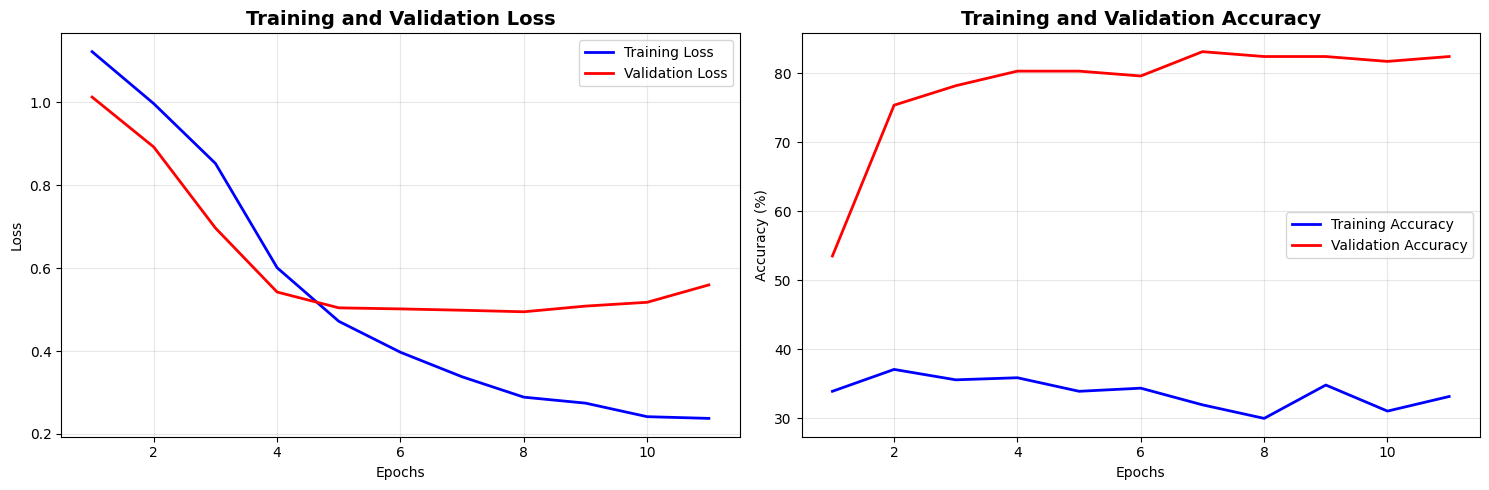

2. Confusion Matrix


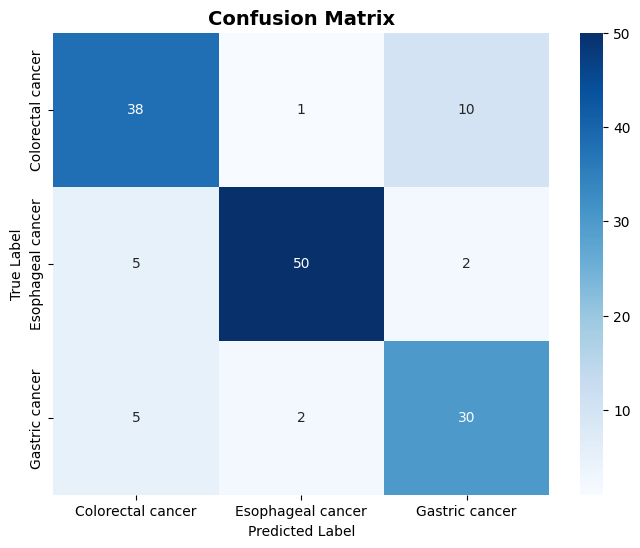

3. ROC Curves


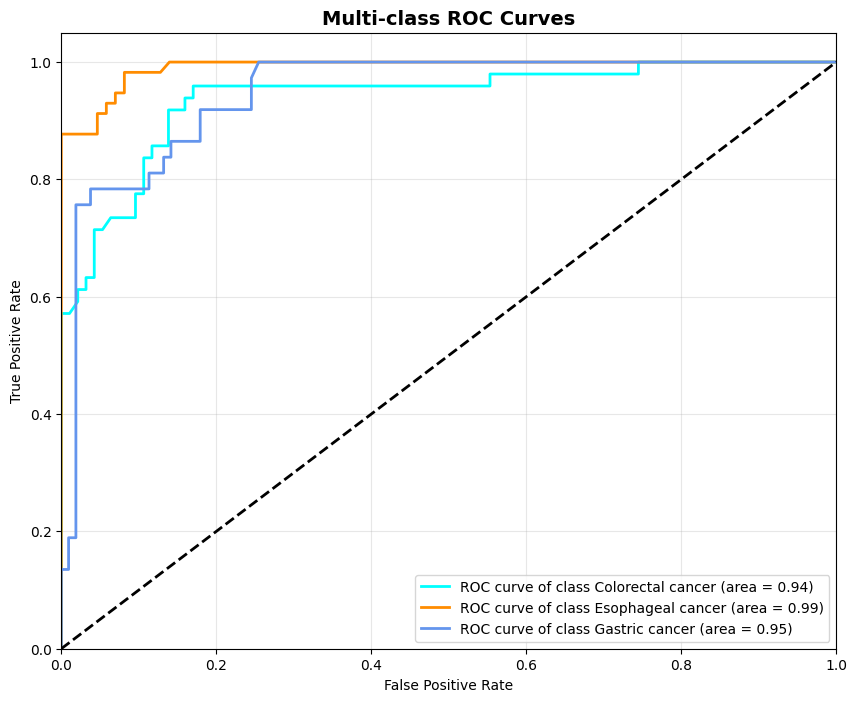

4. Class Distribution


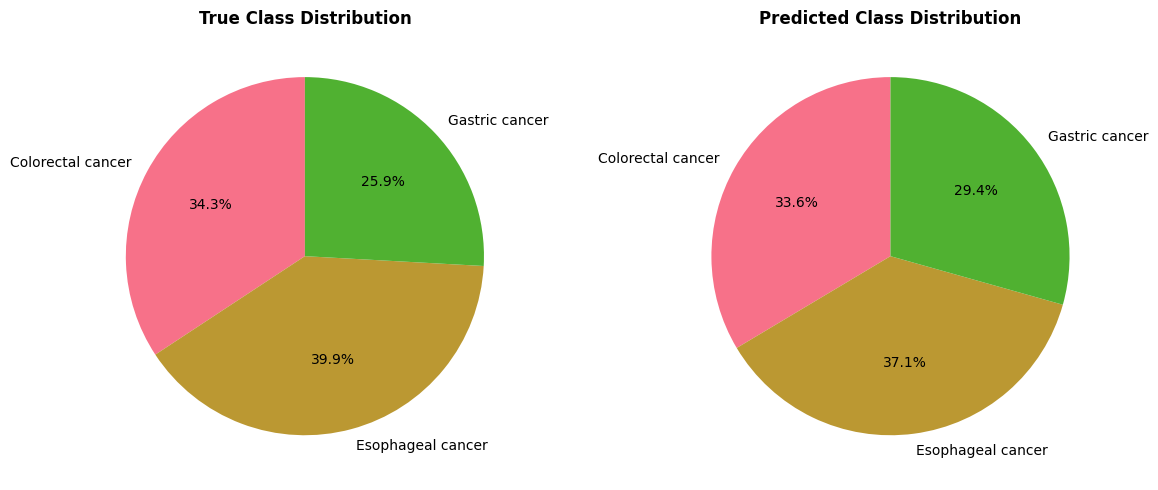

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

# 1: Load and Preprocess Dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    
    X = df.drop(columns=["Cancer Type"])  
    y = df["Cancer Type"]  

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    categorical_columns = X.select_dtypes(include=['object']).columns
    numerical_columns = X.select_dtypes(exclude=['object']).columns

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns) 
    ])
    
    X = preprocessor.fit_transform(X)
    return X, y, label_encoder

def preprocess_data(X, y, test_size=0.3, batch_size=32):
    # train (70%); validation (15%); test (15%) sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, X_train.shape[1], y_train, y_val, y_test

# 2: Define Neural Network Model
class CancerRiskNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CancerRiskNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.4)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        return self.fc4(x) 

# 3: Train Model Function 
def train_model(model, train_loader, val_loader, y_train, y_val, num_epochs=50, patience=3, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        y_train_pred = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            y_train_pred.extend(predicted.cpu().numpy())

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = accuracy_score(y_train.numpy(), np.array(y_train_pred)) * 100

        model.eval()
        total_val_loss = 0
        y_val_pred = []
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                val_outputs = model(X_val_batch)
                val_loss = criterion(val_outputs, y_val_batch)
                total_val_loss += val_loss.item()
                
                _, predicted = torch.max(val_outputs, 1)
                y_val_pred.extend(predicted.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(y_val.numpy(), np.array(y_val_pred)) * 100

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered. Stopping training.")
                break

    return history

def evaluate_model(model, test_loader, y_test, label_encoder):
    model.eval()
    y_true = []
    y_pred = []
    y_proba = []

    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            test_outputs = model(X_test_batch)
            probabilities = torch.softmax(test_outputs, dim=1)
            _, predicted = torch.max(test_outputs, 1)
            
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(y_test_batch.cpu().numpy())
            y_proba.extend(probabilities.cpu().numpy())

    y_proba = np.array(y_proba)
    test_accuracy = accuracy_score(y_true, y_pred) * 100
    
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    return test_accuracy, y_true, y_pred, y_proba

def plot_training_history(history):
    """Plot training and validation loss and accuracy"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return cm

def plot_roc_curves(y_true, y_proba, class_names):
    """Plot ROC curves for multi-class classification"""
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    n_classes = len(class_names)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return roc_auc

def plot_class_distribution(y_true, y_pred, class_names):
    """Plot class distribution comparison"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    true_counts = np.bincount(y_true)
    ax1.pie(true_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    ax1.set_title('True Class Distribution', fontsize=12, fontweight='bold')
    
    pred_counts = np.bincount(y_pred)
    ax2.pie(pred_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Predicted Class Distribution', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":

    file_path = "cancer prediction dataset - My(version(colorec+gastric+esophegael)).csv"
    X, y, label_encoder = load_data(file_path)
    train_loader, val_loader, test_loader, input_size, y_train, y_val, y_test = preprocess_data(X, y)

    num_classes = len(label_encoder.classes_)
    model = CancerRiskNN(input_size, num_classes)
    
    print(f"Input Size: {input_size}")
    print(f"Number of Classes: {num_classes}")


    print("\n Training Neural Network...")
    history = train_model(model, train_loader, val_loader, y_train, y_val)
    
    print("\n Evaluating on Test Data...")
    test_accuracy, y_true, y_pred, y_proba = evaluate_model(model, test_loader, y_test, label_encoder)

    
    print("1. Training History")
    plot_training_history(history)
    
    print("2. Confusion Matrix")
    cm = plot_confusion_matrix(y_true, y_pred, label_encoder.classes_)
    
    print("3. ROC Curves")
    roc_auc = plot_roc_curves(y_true, y_proba, label_encoder.classes_)
    
    print("4. Class Distribution")
    plot_class_distribution(y_true, y_pred, label_encoder.classes_)

### RandomForest + LogisticRegression

Loaded 41 risk factors from Excel
Cancer Risk Prediction System
Dataset loaded: 948 records, 41 unique factors
Created 3000 patients
Features created: 3000 x 59
Risk_Logistic: Accuracy=0.918, AUC=0.944
Risk_RandomForest: Accuracy=0.943, AUC=0.951
Type_Logistic: Accuracy=0.893, AUC=0.914
Type_RandomForest: Accuracy=0.897, AUC=0.920
Best risk model: Risk_RandomForest
Best type model: Type_RandomForest


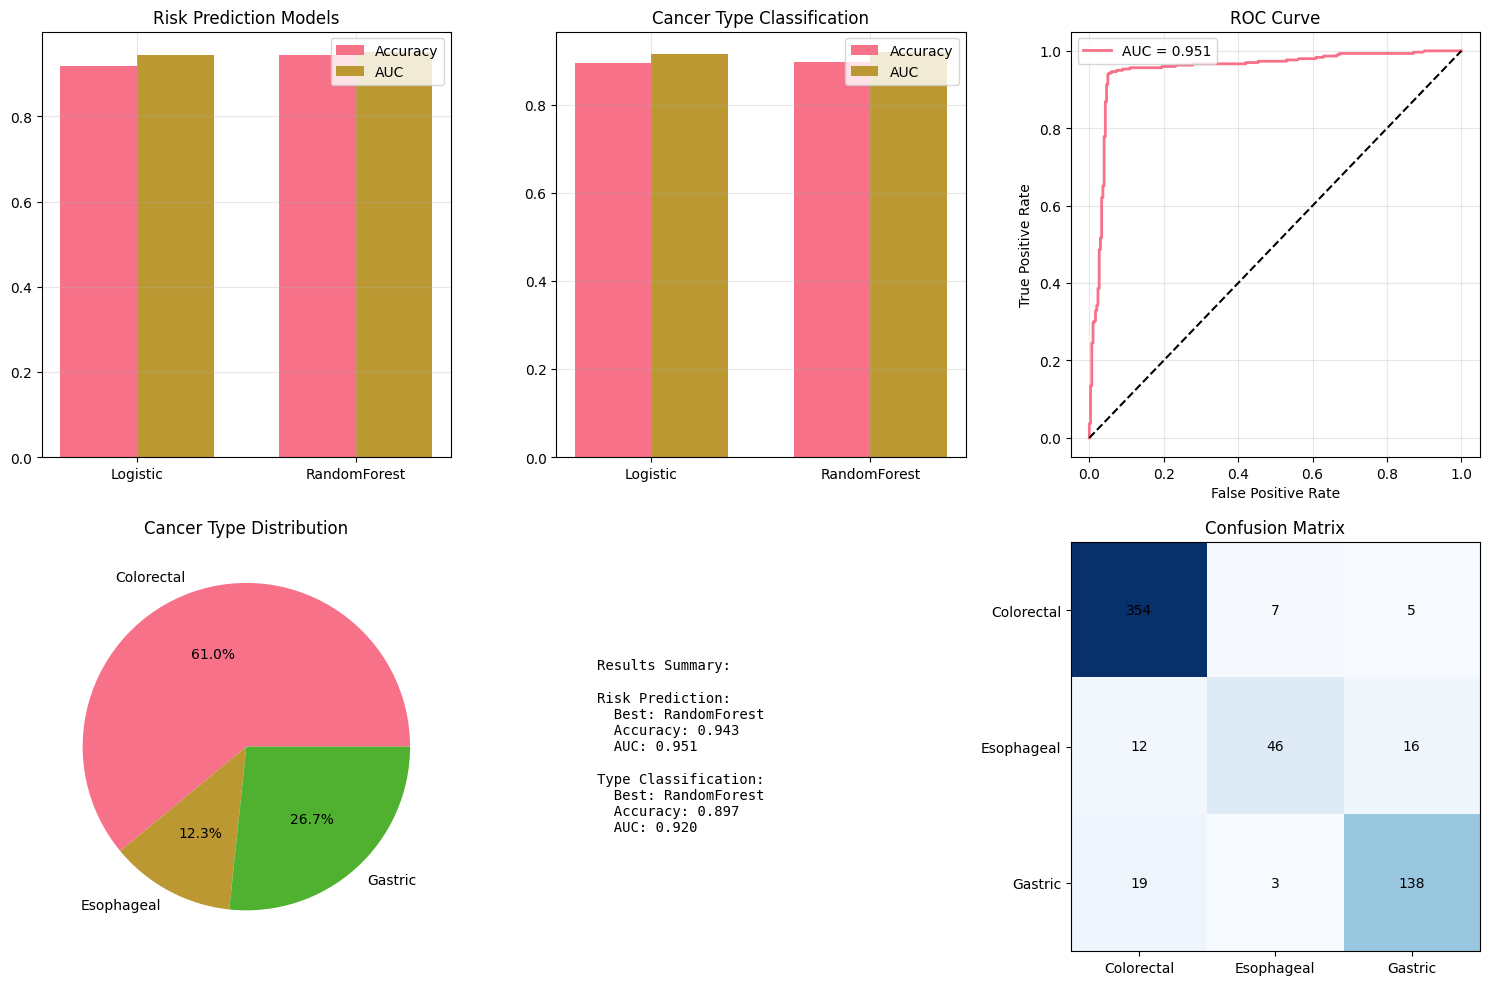

Testing Cancer Risk Prediction System

Testing: High Gastric Risk
Factors: Helicobacter pylori infection, High salt intake, Smoking, Pickled food consumption
Risk: 85.0% (HIGH)
Predicted Type: Gastric cancer
Type Confidence: 88.1%

Testing: High Colorectal Risk
Factors: Red meat consumption, Processed meat consumption, Obesity, Alcohol consumption
Risk: 20.8% (MODERATE)
Predicted Type: Colorectal cancer
Type Confidence: 52.1%

Testing: Healthy Profile
Factors: Mediterranean diet, Regular physical activity, Fruit consumption, Vegetable consumption
Risk: 1.8% (LOW)
Predicted Type: Colorectal cancer
Type Confidence: 83.3%

Testing: Mixed Profile
Factors: Smoking, Fruit consumption, Obesity
Risk: 12.1% (LOW)
Predicted Type: Colorectal cancer
Type Confidence: 58.2%

Testing: Esophageal Risk
Factors: Smoking, Alcohol consumption, Tea consumption (hot)
Risk: 17.3% (MODERATE)
Predicted Type: Esophageal cancer
Type Confidence: 68.5%

System Ready!
Risk Model: Risk_RandomForest (AUC: 0.951)
Type

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

def load_excel_data(file_path='risk_factors_odds_ratios.xlsx'):
    """Load risk factors from Excel file"""
    df = pd.read_excel(file_path)
    df.columns = df.columns.str.strip()
    
    risk_data = {}
    for _, row in df.iterrows():
        factor = str(row.iloc[0]).strip()
        odds_ratio = str(row.iloc[1]).strip()
        
        if ',' in odds_ratio and '.' not in odds_ratio:
            odds_ratio = odds_ratio.replace(',', '.')
        
        try:
            or_value = float(odds_ratio)
            source = str(row.iloc[2]).strip() if len(row) > 2 else 'Excel'
            
            if factor and factor.lower() not in ['nan', '', 'none']:
                risk_data[factor] = {'odds_ratio': or_value, 'source': source}
        except:
            continue
    
    print(f"Loaded {len(risk_data)} risk factors from Excel")
    return risk_data

RISK_DATA = load_excel_data()

def get_evidence_weight(evidence_strength):
    """Convert evidence strength to numerical weight"""
    evidence = str(evidence_strength).lower()
    if 'strong' in evidence:
        return 0.5
    elif 'moderate' in evidence:
        return 0.3
    else:
        return 0.15

def calculate_risk_coefficient(factor, evidence, frequency):
    """Calculate risk coefficient for a factor"""
    if factor not in RISK_DATA:
        base = 0.1 if 'negative' in str(evidence).lower() else -0.1
        freq_mult = min(1.0 + (frequency - 1) * 0.02, 1.10)
        return base * freq_mult
    
    odds_ratio = RISK_DATA[factor]['odds_ratio']
    evidence_weight = get_evidence_weight(evidence)
    freq_mult = min(1.0 + (frequency - 1) * 0.05, 1.15)
    
    if odds_ratio >= 1.0:
        coefficient = (odds_ratio - 1.0) * evidence_weight * freq_mult
    else:
        coefficient = -(1.0 - odds_ratio) * evidence_weight * freq_mult
    
    return coefficient

def load_dataset():
    """Load cancer dataset"""
    df = pd.read_csv('cancer prediction dataset - My(version(colorec+gastric+esophegael)).csv')
    print(f"Dataset loaded: {len(df)} records, {df['Risk Factor'].nunique()} unique factors")
    return df

def create_patient_data(df, num_patients=2000):
    """Create synthetic patient data with risk and cancer type"""
    frequency_counts = df['Risk Factor'].value_counts()
    
    # Process risk factors
    factor_properties = {}
    for _, row in df.iterrows():
        factor = row['Risk Factor']
        effect = row['Effect']
        evidence = row['Evidence Strength']
        cancer_type = row['Cancer Type']
        
        if factor not in factor_properties:
            freq_count = frequency_counts.get(factor, 1)
            freq_mult = min(1.0 + (freq_count - 1) * 0.05, 1.15)
            coeff = calculate_risk_coefficient(factor, evidence, freq_count)
            
            factor_properties[factor] = {
                'effect': 1 if effect == 'Negative' else -1,
                'evidence': get_evidence_weight(evidence),
                'frequency_count': freq_count,
                'frequency_multiplier': freq_mult,
                'clinical_coefficient': coeff,
                'odds_ratio': RISK_DATA.get(factor, {}).get('odds_ratio', 1.0),
                'cancer_types': []
            }
        
        if cancer_type not in factor_properties[factor]['cancer_types']:
            factor_properties[factor]['cancer_types'].append(cancer_type)
    
    cancer_factors = {}
    for _, row in df.iterrows():
        cancer_type = row['Cancer Type']
        factor = row['Risk Factor']
        
        if cancer_type not in cancer_factors:
            cancer_factors[cancer_type] = []
        if factor not in cancer_factors[cancer_type]:
            cancer_factors[cancer_type].append(factor)
    
    patients = []
    all_factors = list(factor_properties.keys())
    cancer_types = list(cancer_factors.keys())
    
    label_encoder = LabelEncoder()
    label_encoder.fit(cancer_types)
    
    for i in range(num_patients):
        primary_cancer = np.random.choice(cancer_types)
        num_factors = np.random.randint(2, 7)
        
        selected_factors = []
        for _ in range(num_factors):
            if np.random.random() < 0.7 and cancer_factors[primary_cancer]:
                factor = np.random.choice(cancer_factors[primary_cancer])
            else:
                factor = np.random.choice(all_factors)
            
            if factor not in selected_factors:
                selected_factors.append(factor)
        
        # min factors
        while len(selected_factors) < 2:
            factor = np.random.choice(all_factors)
            if factor not in selected_factors:
                selected_factors.append(factor)
        
        risk_score = 0
        protective_count = 0
        negative_count = 0
        cancer_scores = {ct: 0 for ct in cancer_types}
        
        for factor in selected_factors:
            if factor in factor_properties:
                props = factor_properties[factor]
                risk_score += props['clinical_coefficient']
                
                if props['effect'] > 0:
                    negative_count += 1
                else:
                    protective_count += 1
                
                for cancer in props['cancer_types']:
                    if cancer in cancer_scores:
                        cancer_scores[cancer] += abs(props['clinical_coefficient'])
        
        # determine cancer type
        if max(cancer_scores.values()) > 0:
            predicted_cancer = max(cancer_scores.items(), key=lambda x: x[1])[0]
        else:
            predicted_cancer = primary_cancer
        
        cancer_encoded = label_encoder.transform([predicted_cancer])[0]
        has_risk = 1 if risk_score > 0.2 else 0
        
        # add some noise
        if np.random.random() < 0.05:
            has_risk = 1 - has_risk
        if np.random.random() < 0.1:
            cancer_encoded = np.random.choice(len(cancer_types))
            predicted_cancer = label_encoder.inverse_transform([cancer_encoded])[0]
        
        patient = {
            'patient_id': i,
            'risk_factors': selected_factors,
            'risk_score': risk_score,
            'has_risk': has_risk,
            'protective_count': protective_count,
            'negative_count': negative_count,
            'cancer_type': predicted_cancer,
            'cancer_encoded': cancer_encoded,
            'cancer_scores': cancer_scores
        }
        patients.append(patient)
    
    print(f"Created {len(patients)} patients")
    return patients, factor_properties, label_encoder, cancer_factors

def calculate_risk_percentage(factors, factor_props):
    """Calculate cancer risk percentage"""
    base_risk = 5.0
    negative_factors = []
    protective_factors = []
    
    for factor in factors:
        if factor in factor_props:
            props = factor_props[factor]
            coeff = props['clinical_coefficient']
            odds_ratio = props['odds_ratio']
            freq_mult = props['frequency_multiplier']
            
            if coeff > 0:
                negative_factors.append({
                    'name': factor,
                    'or': odds_ratio,
                    'freq_mult': freq_mult,
                    'coeff': coeff
                })
            else:
                protective_factors.append({
                    'name': factor,
                    'or': odds_ratio,
                    'freq_mult': freq_mult,
                    'coeff': coeff
                })
    
    negative_multiplier = 1.0
    if negative_factors:
        for factor in negative_factors:
            risk_increase = (factor['or'] - 1.0) * factor['freq_mult']
            enhanced_or = 1.0 + risk_increase
            negative_multiplier *= enhanced_or
    
    risk_after_negative = base_risk * negative_multiplier
    
    if protective_factors:
        for factor in protective_factors:
            risk_reduction = (1.0 - factor['or']) * factor['freq_mult']
            reduction_factor = max(0.1, 1.0 - risk_reduction)
            risk_after_negative *= reduction_factor
    
    final_risk = risk_after_negative
    
    # Quality adjustments
    evidence_qualities = [factor_props[f]['evidence'] for f in factors if f in factor_props]
    freq_qualities = [factor_props[f]['frequency_multiplier'] for f in factors if f in factor_props]
    
    avg_evidence = np.mean(evidence_qualities) if evidence_qualities else 0.5
    avg_frequency = np.mean(freq_qualities) if freq_qualities else 1.0
    
    evidence_adj = (avg_evidence - 0.5) * 0.08
    frequency_adj = (avg_frequency - 1.0) * 0.05
    
    final_risk *= (1 + evidence_adj + frequency_adj)
    final_risk = max(1.0, min(85.0, final_risk))
    
    return final_risk

def create_features(patients, factor_props):
    """Create feature matrix for both tasks"""
    all_factors = list(factor_props.keys())
    features = []
    risk_labels = []
    type_labels = []
    
    for patient in patients:
        feature_row = {}
        
        # binary factor indicators
        for factor in all_factors:
            feature_row[f'has_{factor}'] = 1 if factor in patient['risk_factors'] else 0
        
        # summary features
        feature_row['num_factors'] = len(patient['risk_factors'])
        feature_row['protective_count'] = patient['protective_count']
        feature_row['negative_count'] = patient['negative_count']
        feature_row['protective_ratio'] = patient['protective_count'] / max(1, patient['negative_count'])
        
        # risk calculations
        risk_weighted = 0
        evidence_total = 0
        cumulative_or = 1.0
        freq_enhanced_or = 1.0
        freq_avg = 0
        
        # cancer type scores
        colorectal_score = 0
        gastric_score = 0
        esophageal_score = 0
        
        for factor in patient['risk_factors']:
            if factor in factor_props:
                props = factor_props[factor]
                risk_weighted += props['clinical_coefficient']
                evidence_total += props['evidence']
                cumulative_or *= props['odds_ratio']
                freq_avg += props['frequency_multiplier']
                
                if props['odds_ratio'] >= 1.0:
                    enhanced_or = 1.0 + (props['odds_ratio'] - 1.0) * props['frequency_multiplier']
                else:
                    enhanced_or = props['odds_ratio'] * props['frequency_multiplier']
                freq_enhanced_or *= enhanced_or
                
                for cancer_type in props['cancer_types']:
                    weight = abs(props['clinical_coefficient'])
                    if 'Colorectal' in cancer_type:
                        colorectal_score += weight
                    elif 'Gastric' in cancer_type:
                        gastric_score += weight
                    elif 'Esophageal' in cancer_type:
                        esophageal_score += weight
        
        feature_row['risk_weighted_score'] = risk_weighted
        feature_row['cumulative_or'] = cumulative_or
        feature_row['freq_enhanced_or'] = freq_enhanced_or
        feature_row['avg_evidence'] = evidence_total / max(1, len(patient['risk_factors']))
        feature_row['avg_frequency'] = freq_avg / max(1, len(patient['risk_factors']))
        
        feature_row['has_more_protective'] = 1 if patient['protective_count'] > patient['negative_count'] else 0
        feature_row['has_more_negative'] = 1 if patient['negative_count'] > patient['protective_count'] else 0
        feature_row['is_balanced'] = 1 if patient['negative_count'] == patient['protective_count'] else 0
        
        feature_row['high_freq_factors'] = sum(1 for f in patient['risk_factors'] 
                                             if f in factor_props and factor_props[f]['frequency_count'] >= 5)
        
        feature_row['colorectal_score'] = colorectal_score
        feature_row['gastric_score'] = gastric_score
        feature_row['esophageal_score'] = esophageal_score
        feature_row['max_cancer_score'] = max(colorectal_score, gastric_score, esophageal_score)
        feature_row['has_dominant_type'] = 1 if feature_row['max_cancer_score'] > 0 else 0
        
        features.append(feature_row)
        risk_labels.append(patient['has_risk'])
        type_labels.append(patient['cancer_encoded'])
    
    feature_df = pd.DataFrame(features).fillna(0)
    print(f"Features created: {len(feature_df)} x {len(feature_df.columns)}")
    
    return feature_df, risk_labels, type_labels

def train_models(X, y_risk, y_type):
    """Train both risk and classification models"""
    X_train, X_test, y_risk_train, y_risk_test, y_type_train, y_type_test = train_test_split(
        X, y_risk, y_type, test_size=0.2, random_state=42, stratify=y_risk
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    risk_models = {
        'Risk_Logistic': LogisticRegression(C=1.0, class_weight='balanced', max_iter=1000, random_state=42),
        'Risk_RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
    }
    
    type_models = {
        'Type_Logistic': LogisticRegression(C=1.0, class_weight='balanced', max_iter=1000, random_state=42),
        'Type_RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', random_state=42)
    }

    risk_results = {}
    trained_risk = {}
    
    for name, model in risk_models.items():
        if 'Logistic' in name:
            model.fit(X_train_scaled, y_risk_train)
            y_pred = model.predict(X_test_scaled)
            y_prob = model.predict_proba(X_test_scaled)[:, 1]
        else:
            model.fit(X_train, y_risk_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]
        
        accuracy = accuracy_score(y_risk_test, y_pred)
        auc = roc_auc_score(y_risk_test, y_prob)
        
        risk_results[name] = {
            'accuracy': accuracy,
            'auc': auc,
            'predictions': y_pred,
            'probabilities': y_prob
        }
        trained_risk[name] = model
        print(f"{name}: Accuracy={accuracy:.3f}, AUC={auc:.3f}")
    
    type_results = {}
    trained_type = {}
    
    for name, model in type_models.items():
        if 'Logistic' in name:
            model.fit(X_train_scaled, y_type_train)
            y_pred = model.predict(X_test_scaled)
            y_prob = model.predict_proba(X_test_scaled)
        else:
            model.fit(X_train, y_type_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)
        
        accuracy = accuracy_score(y_type_test, y_pred)
        try:
            auc = roc_auc_score(y_type_test, y_prob, multi_class='ovr', average='weighted')
        except:
            auc = 0.5
        
        type_results[name] = {
            'accuracy': accuracy,
            'auc': auc,
            'predictions': y_pred,
            'probabilities': y_prob
        }
        trained_type[name] = model
        print(f"{name}: Accuracy={accuracy:.3f}, AUC={auc:.3f}")
    
    # best models selection
    best_risk_name = max(risk_results.keys(), key=lambda x: risk_results[x]['auc'])
    best_type_name = max(type_results.keys(), key=lambda x: type_results[x]['accuracy'])
    
    best_risk_model = trained_risk[best_risk_name]
    best_type_model = trained_type[best_type_name]
    
    print(f"Best risk model: {best_risk_name}")
    print(f"Best type model: {best_type_name}")
    
    return (best_risk_model, best_type_model, scaler, 
            risk_results, type_results, X_test, y_risk_test, y_type_test)

def create_predictor(risk_model, type_model, scaler, factor_props, label_encoder):
    """Create prediction function"""
    
    def predict(risk_factors_list):
        risk_pct = calculate_risk_percentage(risk_factors_list, factor_props)
        
        all_factors = list(factor_props.keys())
        features = {}
        
        for factor in all_factors:
            features[f'has_{factor}'] = 1 if factor in risk_factors_list else 0
            
        protective_count = 0
        negative_count = 0
        risk_weighted = 0
        evidence_total = 0
        cumulative_or = 1.0
        freq_enhanced_or = 1.0
        freq_avg = 0
        high_freq_count = 0
        
        colorectal_score = 0
        gastric_score = 0
        esophageal_score = 0
        
        for factor in risk_factors_list:
            if factor in factor_props:
                props = factor_props[factor]
                
                if props['clinical_coefficient'] > 0:
                    negative_count += 1
                else:
                    protective_count += 1
                
                risk_weighted += props['clinical_coefficient']
                evidence_total += props['evidence']
                cumulative_or *= props['odds_ratio']
                freq_avg += props['frequency_multiplier']
                
                if props['odds_ratio'] >= 1.0:
                    enhanced_or = 1.0 + (props['odds_ratio'] - 1.0) * props['frequency_multiplier']
                else:
                    enhanced_or = props['odds_ratio'] * props['frequency_multiplier']
                freq_enhanced_or *= enhanced_or
                
                if props['frequency_count'] >= 5:
                    high_freq_count += 1
                
                for cancer_type in props['cancer_types']:
                    weight = abs(props['clinical_coefficient'])
                    if 'Colorectal' in cancer_type:
                        colorectal_score += weight
                    elif 'Gastric' in cancer_type:
                        gastric_score += weight
                    elif 'Esophageal' in cancer_type:
                        esophageal_score += weight
        
        features['num_factors'] = len(risk_factors_list)
        features['protective_count'] = protective_count
        features['negative_count'] = negative_count
        features['protective_ratio'] = protective_count / max(1, negative_count)
        features['risk_weighted_score'] = risk_weighted
        features['cumulative_or'] = cumulative_or
        features['freq_enhanced_or'] = freq_enhanced_or
        features['avg_evidence'] = evidence_total / max(1, len(risk_factors_list))
        features['avg_frequency'] = freq_avg / max(1, len(risk_factors_list))
        features['has_more_protective'] = 1 if protective_count > negative_count else 0
        features['has_more_negative'] = 1 if negative_count > protective_count else 0
        features['is_balanced'] = 1 if negative_count == protective_count else 0
        features['high_freq_factors'] = high_freq_count
        features['colorectal_score'] = colorectal_score
        features['gastric_score'] = gastric_score
        features['esophageal_score'] = esophageal_score
        features['max_cancer_score'] = max(colorectal_score, gastric_score, esophageal_score)
        features['has_dominant_type'] = 1 if features['max_cancer_score'] > 0 else 0
        
        feature_vector = np.array([list(features.values())])
        
        # risk prediction
        if isinstance(risk_model, LogisticRegression):
            feature_scaled = scaler.transform(feature_vector)
            risk_prob = risk_model.predict_proba(feature_scaled)[0][1]
            has_risk = risk_model.predict(feature_scaled)[0]
        else:
            risk_prob = risk_model.predict_proba(feature_vector)[0][1]
            has_risk = risk_model.predict(feature_vector)[0]
        
        # type prediction
        if isinstance(type_model, LogisticRegression):
            feature_scaled = scaler.transform(feature_vector)
            type_probs = type_model.predict_proba(feature_scaled)[0]
            type_pred = type_model.predict(feature_scaled)[0]
        else:
            type_probs = type_model.predict_proba(feature_vector)[0]
            type_pred = type_model.predict(feature_vector)[0]
        
        predicted_type = label_encoder.inverse_transform([type_pred])[0]
        
        cancer_types = label_encoder.classes_
        type_prob_dict = {}
        for i, cancer_type in enumerate(cancer_types):
            type_prob_dict[cancer_type] = type_probs[i]
        
        # Risk level
        if risk_pct < 15:
            risk_level = "LOW"
        elif risk_pct < 40:
            risk_level = "MODERATE"
        else:
            risk_level = "HIGH"
        
        return {
            'cancer_risk_percentage': risk_pct,
            'has_significant_risk': bool(has_risk),
            'model_confidence': risk_prob,
            'risk_level': risk_level,
            'protective_factors': protective_count,
            'negative_factors': negative_count,
            'cumulative_odds_ratio': cumulative_or,
            'freq_enhanced_odds_ratio': freq_enhanced_or,
            'clinical_risk_score': risk_weighted,
            'predicted_cancer_type': predicted_type,
            'cancer_type_probabilities': type_prob_dict,
            'cancer_type_confidence': max(type_probs),
            'cancer_type_scores': {
                'colorectal': colorectal_score,
                'gastric': gastric_score,
                'esophageal': esophageal_score
            }
        }
    
    return predict

def visualize_results(risk_results, type_results, X_test, y_risk_test, y_type_test):
    """Create visualization of results"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    risk_names = list(risk_results.keys())
    risk_accs = [risk_results[name]['accuracy'] for name in risk_names]
    risk_aucs = [risk_results[name]['auc'] for name in risk_names]
    
    x = np.arange(len(risk_names))
    width = 0.35
    axes[0, 0].bar(x - width/2, risk_accs, width, label='Accuracy')
    axes[0, 0].bar(x + width/2, risk_aucs, width, label='AUC')
    axes[0, 0].set_title('Risk Prediction Models')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels([name.replace('Risk_', '') for name in risk_names])
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Type model comparison
    type_names = list(type_results.keys())
    type_accs = [type_results[name]['accuracy'] for name in type_names]
    type_aucs = [type_results[name]['auc'] for name in type_names]
    
    axes[0, 1].bar(x - width/2, type_accs, width, label='Accuracy')
    axes[0, 1].bar(x + width/2, type_aucs, width, label='AUC')
    axes[0, 1].set_title('Cancer Type Classification')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels([name.replace('Type_', '') for name in type_names])
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # ROC curve
    best_risk = max(risk_results.keys(), key=lambda x: risk_results[x]['auc'])
    risk_probs = risk_results[best_risk]['probabilities']
    
    fpr, tpr, _ = roc_curve(y_risk_test, risk_probs)
    axes[0, 2].plot(fpr, tpr, linewidth=2, label=f'AUC = {risk_results[best_risk]["auc"]:.3f}')
    axes[0, 2].plot([0, 1], [0, 1], 'k--')
    axes[0, 2].set_xlabel('False Positive Rate')
    axes[0, 2].set_ylabel('True Positive Rate')
    axes[0, 2].set_title('ROC Curve')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    type_counts = Counter(y_type_test)
    cancer_types = ['Colorectal', 'Esophageal', 'Gastric']
    counts = [type_counts.get(i, 0) for i in range(3)]
    
    axes[1, 0].pie(counts, labels=cancer_types, autopct='%1.1f%%')
    axes[1, 0].set_title('Cancer Type Distribution')
    
    best_type = max(type_results.keys(), key=lambda x: type_results[x]['accuracy'])
    summary = f"""Results Summary:

Risk Prediction:
  Best: {best_risk.replace('Risk_', '')}
  Accuracy: {risk_results[best_risk]['accuracy']:.3f}
  AUC: {risk_results[best_risk]['auc']:.3f}

Type Classification:
  Best: {best_type.replace('Type_', '')}
  Accuracy: {type_results[best_type]['accuracy']:.3f}
  AUC: {type_results[best_type]['auc']:.3f}"""
    
    axes[1, 1].text(0.1, 0.5, summary, transform=axes[1, 1].transAxes, 
                   fontsize=10, verticalalignment='center', fontfamily='monospace')
    axes[1, 1].axis('off')
    
    # Confusion matrix
    best_type_model = max(type_results.keys(), key=lambda x: type_results[x]['accuracy'])
    type_preds = type_results[best_type_model]['predictions']
    
    cm = confusion_matrix(y_type_test, type_preds)
    axes[1, 2].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[1, 2].set_title('Confusion Matrix')
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[1, 2].text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    
    axes[1, 2].set_xticks(range(3))
    axes[1, 2].set_yticks(range(3))
    axes[1, 2].set_xticklabels(cancer_types)
    axes[1, 2].set_yticklabels(cancer_types)
    
    plt.tight_layout()
    plt.show()

def test_predictions(predictor):
    """Test the prediction system"""
    test_cases = [
        {
            'name': 'High Gastric Risk',
            'factors': ['Helicobacter pylori infection', 'High salt intake', 'Smoking', 'Pickled food consumption']
        },
        {
            'name': 'High Colorectal Risk',
            'factors': ['Red meat consumption', 'Processed meat consumption', 'Obesity', 'Alcohol consumption']
        },
        {
            'name': 'Healthy Profile',
            'factors': ['Mediterranean diet', 'Regular physical activity', 'Fruit consumption', 'Vegetable consumption']
        },
        {
            'name': 'Mixed Profile',
            'factors': ['Smoking', 'Fruit consumption', 'Obesity']
        },
        {
            'name': 'Esophageal Risk',
            'factors': ['Smoking', 'Alcohol consumption', 'Tea consumption (hot)']
        }
    ]
    
    print("Testing Cancer Risk Prediction System")
    print("="*50)
    
    for case in test_cases:
        print(f"\nTesting: {case['name']}")
        print(f"Factors: {', '.join(case['factors'])}")
        
        result = predictor(case['factors'])
        
        print(f"Risk: {result['cancer_risk_percentage']:.1f}% ({result['risk_level']})")
        print(f"Predicted Type: {result['predicted_cancer_type']}")
        print(f"Type Confidence: {result['cancer_type_confidence']*100:.1f}%")

def main():  
    df = load_dataset()
    
    patients, factor_props, label_encoder, cancer_factors = create_patient_data(df, 3000)

    X, y_risk, y_type = create_features(patients, factor_props)

    (risk_model, type_model, scaler, risk_results, type_results, 
     X_test, y_risk_test, y_type_test) = train_models(X, y_risk, y_type)

    visualize_results(risk_results, type_results, X_test, y_risk_test, y_type_test)

    predictor = create_predictor(risk_model, type_model, scaler, factor_props, label_encoder)
    
    test_predictions(predictor)

    best_risk = max(risk_results.keys(), key=lambda x: risk_results[x]['auc'])
    best_type = max(type_results.keys(), key=lambda x: type_results[x]['accuracy'])
    
    return risk_model, type_model, predictor, factor_props, label_encoder

if __name__ == "__main__":
    models = main()